In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-video-games/steam-200k.csv


# Kütüphanelerin Yüklenmesi

In [2]:
from matplotlib import pyplot as plt
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Verilerin keşfi

In [3]:
df = pd.read_csv("/kaggle/input/steam-video-games/steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])
df.head(10)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [4]:
# "play" eylemi için bilgiler, bana daha alakalı görünüyor.
# burada, ortalama hesaplamada alakalı olmayan Hours = 1.0 ile action = 'purchase'i hariç tutmak istiyoruz

df.loc[df['Action'] == 'play'].describe().T

,count,mean,std,min,25%,50%,75%,max
UserID,70489.0,1.058812e+08,7.150365e+07,5250.0,49342564.0,91690667.0,155673786.0,309903146.0
Hours,70489.0,4.887806e+01,2.293352e+02,0.1,1.0,4.5,19.1,11754.0
Other,70489.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0


Bu kodda, bir oyuncunun her oyun satın aldığında onu oynayıp oynamadığını kontrol edeceğiz.

In [5]:
# İlk 20 UserID'yi belirle (verinin sırasına göre)
top_20_users = df['UserID'].drop_duplicates().head(20)

# Bu UserID'ler için gruplama yap
values = df[df['UserID'].isin(top_20_users)].groupby(['UserID', 'Action']).size()

# İlk 40 sonucu göster
values.head(40)




UserID     Action  
26122540   play          7
           purchase     10
30007387   purchase      2
53875128   play        197
           purchase    505
59945701   play         22
           purchase     43
63024728   play          1
           purchase      1
76933274   play          1
           purchase      1
126340495  play         17
           purchase     29
140954425  play          1
           purchase      1
150128162  play          1
           purchase      1
151603712  play         26
           purchase     40
176410694  play          1
           purchase      1
187131847  play          1
           purchase      1
194895541  play          2
           purchase      2
197278511  play          1
           purchase      1
197455089  play          1
           purchase      1
218323237  play          3
           purchase      3
234941318  purchase      1
256193015  purchase      1
297811211  play          3
           purchase      3
302186258  play          1
        

Bazı kullanıcılar için satın alınan oyunlar hakkında bazı bilgilere sahip olduğumuzu ancak oynanan zamanla ilgili hiçbir bilgiye sahip olmadığımızı görebiliyoruz, bu nedenle bu eğilimi aşağıda ele almaya çalışacağız.

In [6]:
print("Oyun Sayısı : {0}".format(len(df.Game.unique())))
print("Kullanıcı Sayısı : {0}".format(len(df.UserID.unique())))
print("Toplam Satın Alma Sayısı  : {0}".format(len(df.loc[df['Action'] == 'purchase'])))
print("Toplam oyun sayısı bilgisi  : {0}".format(len(df.loc[df['Action'] == 'play'])))

Oyun Sayısı : 5155
Kullanıcı Sayısı : 12393
Toplam Satın Alma Sayısı  : 129511
Toplam oyun sayısı bilgisi  : 70489


# Oyun ve Kullanıcı Analizi
Öncelikle her oyunun kaç kez satın alındığını çizeceğiz. Ayrıca en çok satın alınan oyunların en çok oynanan oyunlar olup olmadığını görmek için kaç saat oynandığını da çizeceğiz.

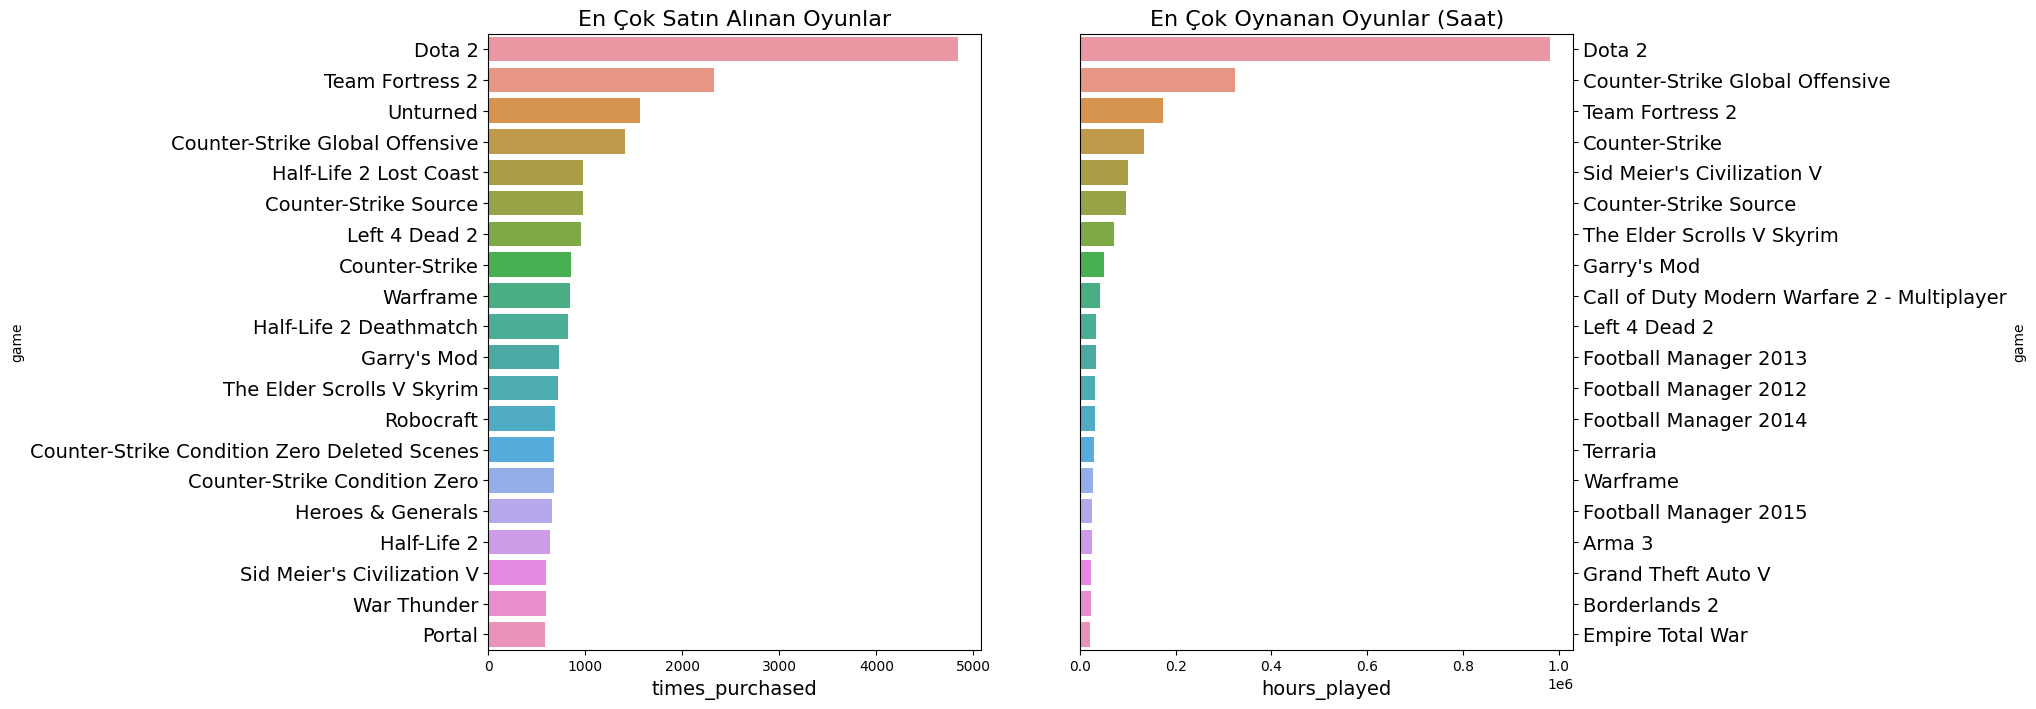

In [7]:
# Parametre
nb_games = 20

# Satın alma analizleri
df_purchase = df.loc[df['Action'] == 'purchase']
purchased_times = (
    df_purchase.groupby('Game')['Game']
    .agg('count')
    .sort_values(ascending=False)
)
purchased_times = pd.DataFrame({
    'game': purchased_times.index, 
    'times_purchased': purchased_times.values
})[:nb_games]  # İlk 10 oyunu seç

# Oynanma süreleri analizleri
df_play = df.loc[df['Action'] == 'play']  # df_play değişkenini tanımlıyoruz
hours_played = (
    df_play.groupby('Game')['Hours']
    .agg("sum")  # np.sum yerine "sum" kullanıldı
    .sort_values(ascending=False)
)
hours_played = pd.DataFrame({
    'game': hours_played.index, 
    'hours_played': hours_played.values
})[:nb_games]


# Görselleştirme
fig, ax = plt.subplots(1, 2, figsize=(14, 8))  # Sabit yükseklik için 8 kullanıldı

# Satın alma grafiği
sns.barplot(y='game', x='times_purchased', data=purchased_times, ax=ax[0])
ax[0].set_title('En Çok Satın Alınan Oyunlar', fontsize=16)

# Oynanma süresi grafiği
sns.barplot(y='game', x='hours_played', data=hours_played, ax=ax[1])
ax[1].set_title('En Çok Oynanan Oyunlar (Saat)', fontsize=16)

# Sağ eksen ayarı
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

# Yazı boyutlarını düzenle
for i in range(2):
    ax[i].tick_params(axis='y', labelsize=14)  # Daha okunaklı yazı boyutu
    ax[i].xaxis.label.set_size(14)

plt.show()



Şimdi en aktif kullanıcıları oynanan saate göre sıralayalım ve oynadıkları oyunlara bir göz atalım.

<Axes: xlabel='hours_played', ylabel='game'>

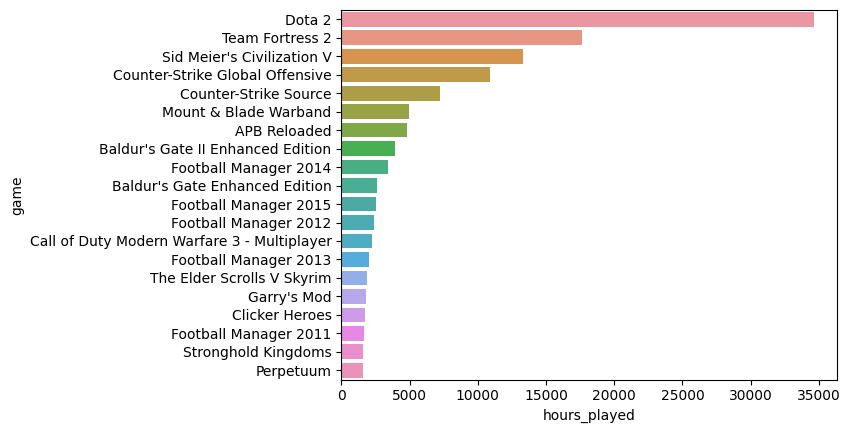

In [8]:
#En çok oyun saatine sahip olan ilk 20 oyuncu
top = 20

# Kullanıcı bazında toplam oynanma süresi hesaplama
user_counts = df.groupby('UserID')['Hours'].agg("sum").sort_values(ascending=False)[0:top]

# Bu kullanıcıların oynadığı oyunları seçme
mask = df['UserID'].isin(user_counts.index)
df_infos_user = df.loc[mask].loc[df['Action'] == 'play']

# Oynanma süreleri analizi
hours_played = df_infos_user.groupby('Game')['Hours'].agg("sum").sort_values(ascending=False)

# En çok oynanan 20 oyunu seçme (direkt dilimleme)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values}).iloc[:top]

# Görselleştirme
sns.barplot(y='game', x='hours_played', data=hours_played)




En çok oynayan oyuncuların sayısı için çeşitli değerleri test ederek, CIvilization V gibi bazı şaşırtıcı oynanmış oyunların en çok oynanan oyunlar arasında olduğunu ancak en çok oynanan oyunlar arasında yalnızca 5. sırada yer aldığını gözlemliyoruz. Mount & Blade Warband için de aynı şey geçerli, tüm kullanıcılar için en çok oynanan ilk 20 oyun arasında görünmüyor ancak yalnızca en aktif oyuncuları tutarak en üstte yer alıyor. Şimdi bu belirli oyunlar için oynanan sürenin dağılımını gözlemlemeye çalışacağız ve belki de daha az oynanan ünlü oyunları, daha az bilinen ancak hardcore oyun oynamaya neden olan bazı oyunlardan farklılaştıracağız.

<Axes: xlabel='Hours', ylabel='Game'>

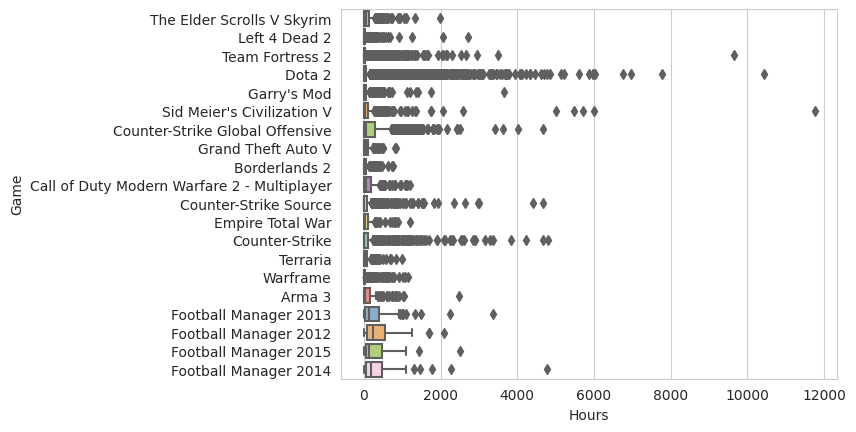

In [9]:
# 1. En çok oynanan 20 oyunun seçilmesi
nb_top_games = 20  # İlk 20 oyun

# 2. Oynanma sürelerinin hesaplanması
hours_played = df_play.groupby('Game')['Hours'].agg("sum").sort_values(ascending=False)  # Her bir oyunun toplam oynama süresini hesapla ve azalan sırayla sırala

# 3. En çok oynanan 20 oyunun seçilmesi
top_played_games = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_top_games]  
# "game" ve "hours_played" sütunları oluşturulur, ve ilk 20 oyun seçilir

# 4. Bu oyunları oynayan kullanıcıları seçme
mask = df['Game'].isin(top_played_games['game'])  # 'Game' sütunundaki değerlerin en çok oynanan 20 oyunla eşleşmesini kontrol et

# 5. Bu oyunları oynayan kullanıcıların oynama sürelerini filtreleme
df_infos_user = df.loc[mask].loc[df['Action'] == 'play'][['Hours', 'Game']]  # sadece "play" aksiyonları ve oyunlar için "Hours" ve "Game" sütunları seçilir

# 6. Görselleştirme ayarları
sns.set_style("whitegrid")  # Grafik için beyaz arka plan ve grid stili ayarlanır

# 7. Oynanma sürelerinin oyunlara göre dağılımının boxplot ile görselleştirilmesi
sns.boxplot(x="Hours", y="Game", data=df_infos_user, palette="Set3")  
# Oynama sürelerini, her oyun için bir boxplot olarak görselleştirir.



Gördüğümüz gibi, bazı oyunlar ortalama oynanış sürelerine oldukça yakın kalırken, FM veya Civilization gibi bazılarının ise çok düşük oynanış süreleri var.

# Kullanıcı Sınıflandırması
Burada, oyuncuların profilini belirlemek için kullanıcılar için bazı kümeler bulmaya çalışacağız. Bunu yapmak için şunları kullanmaya çalışacağız:

* Satın Alınan Oyun Sayısı ve Oynanan Saat Sayısı
* Oynanan Oyun Sayısı ve Oynanan Saat Sayısı
* Eylem Sayısı ve Oynanan Saat Sayısıayısıt Sayısı

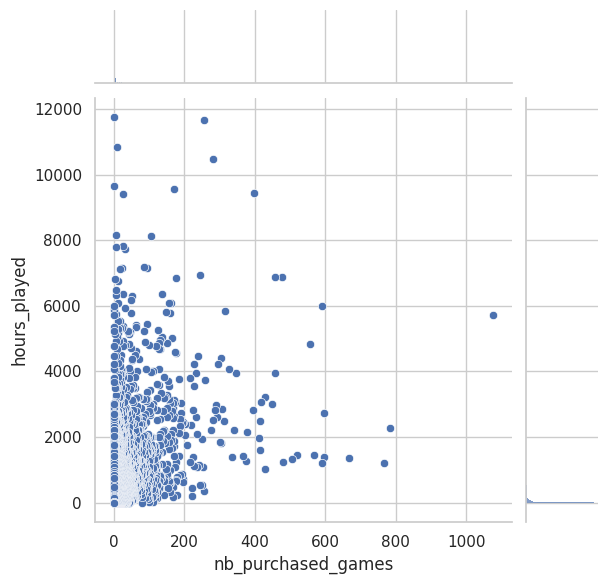

In [10]:
# Veriye inf değerlerini NaN ile değiştirme
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Oyun satın alım işlemleri
df_purchased_games = df.loc[df['Action'] == 'purchase']
# Oynama işlemleri
df_played_games = df.loc[df['Action'] == 'play']

# Kullanıcı bazında satın alınan oyun sayısını hesapla
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)

# Kullanıcı bazında oynanan saatleri hesapla
hours_played = df_played_games.groupby('UserID')['Hours'].agg("sum").sort_values(ascending=False)

# Kullanıcılar için DataFrame oluşturma
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

# İki DataFrame'i birleştirerek kullanıcı başına satın alınan oyun sayısı ve oynama süresi
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')

# Joint plot ile görselleştirme
sns.set(style="whitegrid")
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)


Bunda bir desen bulmak zor... Y üzerinde logaritmik ölçeği deneyelim

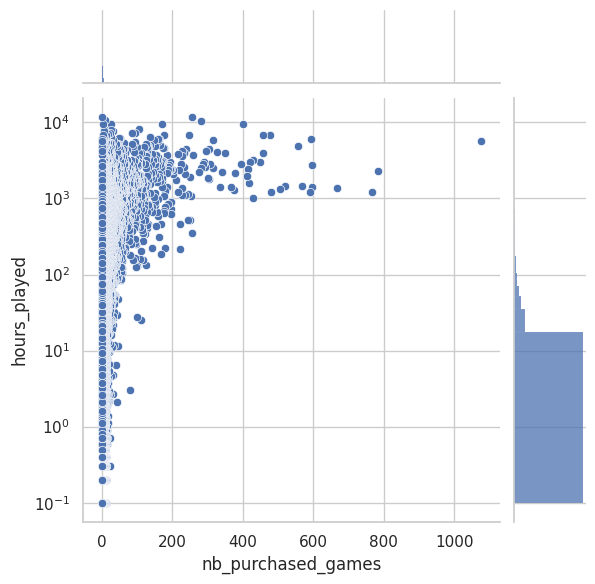

In [11]:
# jointplot fonksiyonu ile iki değişken arasındaki ilişkiyi görselleştir
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )  # 'nb_purchased_games' ve 'hours_played' arasındaki ilişkiyi gösterir

# Grafik üzerinde ortak eksen (joint axis) üzerinde değişiklik yapmak için 'ax_joint' özelliğini kullanıyoruz
ax = g.ax_joint

# Y eksenini logaritmik ölçekle yeniden ayarlıyoruz, bu sayede verinin dağılımı daha iyi gözlemlenebilir
ax.set_yscale('log')

# Grafik üzerinde sağdaki marjinal Y eksenini de logaritmik ölçekle ayarlıyoruz
g.ax_marg_y.set_yscale('log')

# Grafiği görüntüle
g


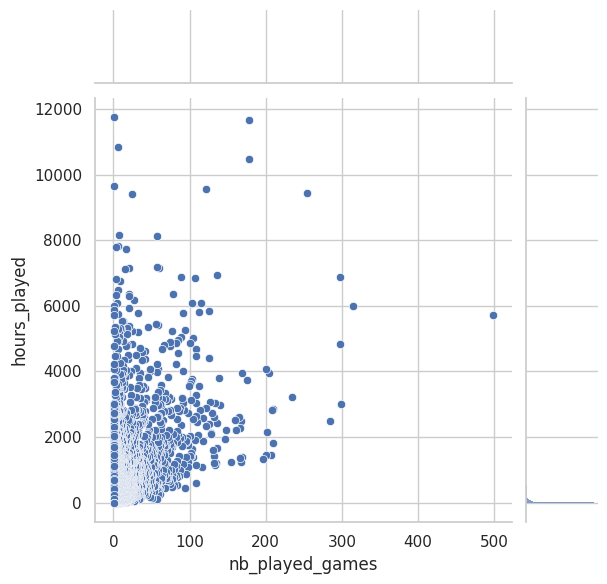

In [12]:
# Kullanıcı bazında oynadıkları oyun sayısını hesaplıyoruz
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
# 'groupby' ile 'UserID' başına oyun sayısını hesaplıyoruz ve 'count' ile her kullanıcı için oyun sayısını alıyoruz.
# 'sort_values' ile oyun sayısına göre azalan şekilde sıralıyoruz.

# Kullanıcı bazında oynanan saatleri hesaplıyoruz
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)
# 'groupby' ile 'UserID' başına oynama sürelerini hesaplıyoruz ve 'np.sum' ile toplam saatleri hesaplıyoruz.
# 'sort_values' ile toplam saatlere göre azalan sıralama yapıyoruz.

# Kullanıcılar için DataFrame oluşturma
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
# Oynanan oyun sayısı ile bir DataFrame oluşturuyoruz. 'UserID' ve 'nb_played_games' (oyun sayısı) sütunlarını içeriyor.

user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})
# Oynanan saatler ile bir DataFrame oluşturuyoruz. 'UserID' ve 'hours_played' (oynanma süresi) sütunlarını içeriyor.

# Kullanıcı başına oyun sayısı ve toplam oynama süresi bilgilerini birleştiriyoruz
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')
# 'UserID' üzerinden her iki DataFrame'i birleştiriyoruz. Bu sayede her kullanıcı için oyun sayısı ve oynama süresi bilgisi tek bir tabloda olacak.

# jointplot ile görselleştirme yapıyoruz
sns.jointplot(x="nb_played_games", y="hours_played", data=data )  # , kind="reg"
# 'nb_played_games' (oynanan oyun sayısı) ve 'hours_played' (oynanan toplam saat) arasındaki ilişkiyi görselleştiren bir jointplot grafiği oluşturuluyor.
# Bu plotta hem her iki değişkenin dağılımlarını, hem de bunlar arasındaki ilişkiyi görebiliriz.
# Eğer 'kind="reg"' eklersek, doğrusal regresyon çizgisi de eklenir.



Y ekseninde logaritmik ölçekle

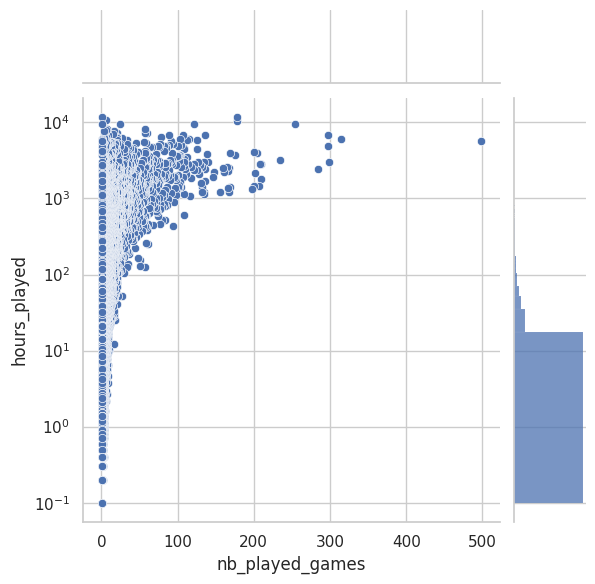

In [13]:
# jointplot ile görselleştirme yapıyoruz
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )  # , kind="reg"
# 'nb_played_games' (oynanan oyun sayısı) ve 'hours_played' (oynanan toplam saat) arasındaki ilişkiyi görselleştiren bir jointplot grafiği oluşturuluyor.
# Eğer 'kind="reg"' parametresi eklenirse, doğrusal regresyon çizgisi eklenir.

# 'ax_joint' üzerinden ana grafik eksenlerine erişiyoruz
ax = g.ax_joint
# Burada 'g' değişkeni jointplot objesini tutuyor. 'ax_joint', jointplot içindeki ana ekseni ifade eder.

# Y eksenini logaritmik skala olarak değiştiriyoruz
ax.set_yscale('log')
# Bu işlem, Y eksenindeki verileri logaritmik skala ile gösterir. Bu, özellikle büyük sayılara sahip verilerde daha anlamlı bir görselleştirme sağlar.

# Marjinal Y eksenini (yan taraftaki histogram) de logaritmik skala yapıyoruz
g.ax_marg_y.set_yscale('log')
# Marjinal eksen, veri kümesinin marjinal dağılımlarını (histogramlar) gösterir. Bu satır ile, marjinal eksende de logaritmik skala uygulanır.

# Görselleştirmeyi gösteriyoruz
g
# Son olarak, oluşturulan jointplot görselleştirmesini ekranda gösteririz.


Veri setinde çok fazla gürültü var, bu saçma değerleri ortadan kaldırarak noktaların özüne daha kesin bir şekilde odaklanmaya çalışmalıyız.

<Axes: >

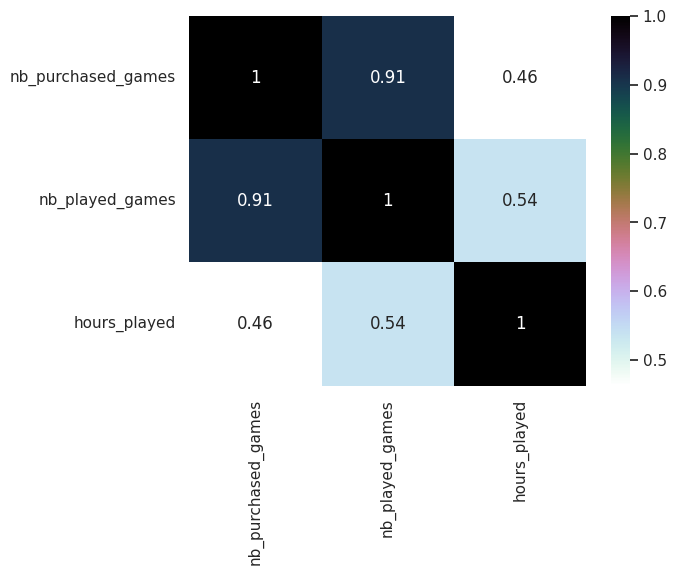

In [14]:
# 'user_df_purchased_games' DataFrame'i ile 'data' DataFrame'ini 'UserID' üzerinde birleştiriyoruz
temp = pd.merge(user_df_purchased_games, data, on='UserID')
# Bu işlem, kullanıcı bazında satın alınan oyun sayısını içeren 'user_df_purchased_games' DataFrame'i ile
# satın alınan oyun sayısı ve oynanma süresi hakkında bilgi içeren 'data' DataFrame'ini birleştirir. Ortak sütun 'UserID' olduğu için buna göre birleştirme yapılır.

# temp DataFrame'ini kopyalayarak çalışmaya devam ediyoruz
temp = temp.copy()
# 'temp.copy()' fonksiyonu, orijinal veriye zarar vermeden bu DataFrame'in bir kopyasını oluşturur.

# 'UserID' sütununu kaldırıyoruz çünkü k-means algoritması bu sütunu kullanmayacak
del temp['UserID']
# K-means algoritması genellikle sayısal özelliklerle çalışır ve 'UserID' gibi kategorik bir sütun gereksizdir.
# Bu yüzden 'UserID' sütununu kaldırıyoruz, çünkü sadece sayısal sütunlarla çalışmak istiyoruz.

# Heatmap oluşturuyoruz: temp DataFrame'indeki sayısal sütunlar arasındaki korelasyonu görselleştiriyoruz
sns.heatmap(temp.corr(), annot=True, cmap='cubehelix_r')
# 'temp.corr()' fonksiyonu, DataFrame'deki sayısal sütunlar arasındaki Pearson korelasyon matrisini hesaplar.
# 'sns.heatmap()' fonksiyonu ise bu korelasyon matrisini görselleştirir.
# - 'annot=True': Korelasyon değerlerinin her hücrede yazılı olmasını sağlar.
# - 'cmap="cubehelix_r"': Renk haritasını "cubehelix_r" olarak belirler. Bu, estetik ve okunabilir bir renk paletidir.


Mantıksal olarak, oynanan oyun sayısı ile satın alınan oyun sayısı arasında güçlü bir korelasyon var.

# K- Means Metodu: 

K-Means, denetimsiz öğrenme (unsupervised learning) algoritmalarından biridir ve veri analizi, kümeleme (clustering) gibi sorunları çözmek için sıklıkla kullanılır. K-Means, verileri gruplara ayırarak benzer özelliklere sahip verileri bir araya getirmeyi amaçlar.

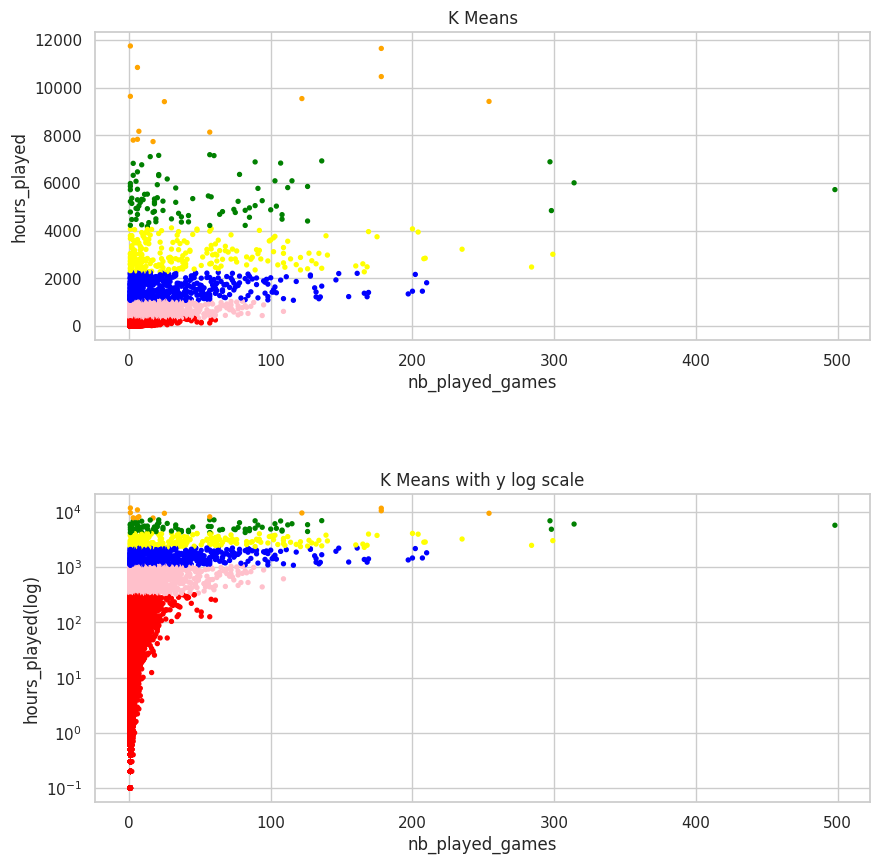

In [15]:
# K Means
temp = data.copy()
del temp['UserID']  # 'UserID' sütununu kaldırıyoruz çünkü bu özellik KMeans için gereksizdir

# Küme sayısını belirliyoruz
N_CLUSTERS = 6  # KMeans için 6 küme kullanacağız

# 'temp' DataFrame'ini NumPy array formatına dönüştürerek KMeans algoritması için hazırlıyoruz
train_data = temp.values  # pandas DataFrame'i NumPy array formatına dönüştürülüyor
# Bu adımda, .values ile DataFrame'i NumPy array'e dönüştürüyoruz, bu Pandas 1.0 ve sonrasında önerilen yöntemdir.

# KMeans algoritmasını sklearn kütüphanesinden kullanıyoruz
km = KMeans(n_clusters=N_CLUSTERS)  # KMeans modeli oluşturuluyor, burada 6 küme belirlendi
km.fit(train_data)  # KMeans algoritmasını veriler üzerinde eğitiyoruz

# Küme atamalarını alıyoruz
labels = km.labels_  # KMeans modelinin her bir veri için küme etiketlerini alıyoruz (0'dan n_clusters-1'e kadar değerler)

# Sonuçları bir DataFrame'e dönüştürerek daha kolay bir şekilde analiz edilebilir hale getiriyoruz
LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

# Küme etiketlerine göre her veri için renk belirliyoruz
label_color = [LABEL_COLOR_MAP[l] for l in labels]

# Kümeleme sonuçlarını görselleştirmek için bir figür oluşturuyoruz
fig, ax = plt.subplots(2, 1, figsize=(10, 10))  # 2 satır, 1 sütun şeklinde iki alt grafik oluşturuyoruz

# Grafikler arasındaki boşluğu artırıyoruz
plt.subplots_adjust(hspace=0.5)  # hspace parametresi ile boşluk ayarı

# İlk grafik: Kümeleme sonuçlarını görselleştiriyoruz
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
# x ekseni: 'nb_played_games', y ekseni: 'hours_played'
# Küme etiketlerine göre renkler atanır ('label_color' listesi)
# 's=8' ile nokta boyutunu belirliyoruz, 'marker='o'' ile nokta şekli ayarlanır
ax[0].set_xlabel('nb_played_games')  # x eksenine etiket ekliyoruz
ax[0].set_ylabel('hours_played')  # y eksenine etiket ekliyoruz
ax[0].set_title('K Means')  # Başlık ekliyoruz

# İkinci grafik: 'y' ekseninin logaritmik ölçeğe dönüştürülmesi
ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
# Aynı veriyi kullanıyoruz, ancak y eksenini logaritmik ölçekte gösteriyoruz
ax[1].set_xlabel('nb_played_games')  # x eksenine etiket ekliyoruz
ax[1].set_ylabel('hours_played(log)')  # y eksenine logaritmik etiket ekliyoruz
ax[1].set_title('K Means with y log scale')  # Başlık ekliyoruz
ax[1].set_yscale('log')  # y eksenini logaritmik ölçeğe dönüştürüyoruz


# Gaussian Mixture Metodu: 

Bu metod kullanılarak veri üzerinde kümeleme işlemi yapılır ve bu kümeler görselleştirilir. 

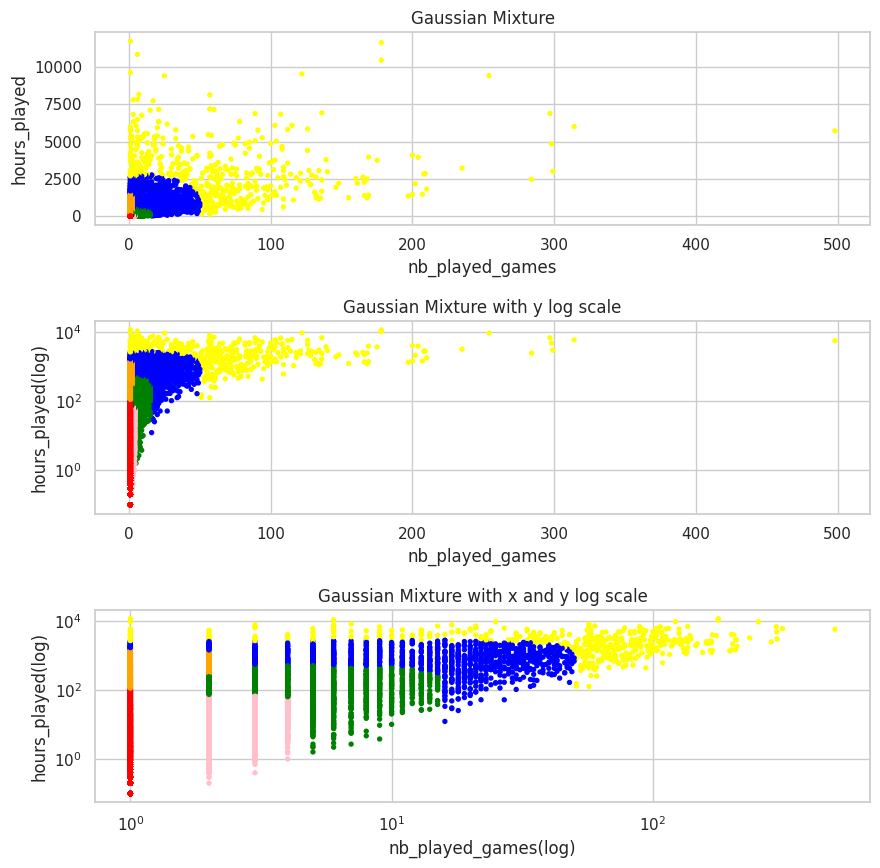

In [16]:
# Farklı kovaryans türlerini tanımlıyoruz
cov_types = ['spherical', 'diag', 'tied', 'full']

# Gaussian Mixture Model (GMM) oluşturuyoruz
gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')

# Modeli veriye fit ediyoruz
gm.fit(train_data)

# Eğitim verisi üzerinde kümeleri tahmin ediyoruz
y_train_pred = gm.predict(train_data)

# Küme etiketlerine göre renkleri belirliyoruz
label_color = [LABEL_COLOR_MAP[l] for l in y_train_pred]

# Sonuçları görselleştirmek için 3 alt grafik içeren bir figür oluşturuyoruz
fig, ax = plt.subplots(3, 1, figsize=(10, 10))  # 3 satır, 1 sütunluk bir düzen ile

# Grafikler arasındaki boşluğu artırıyoruz
plt.subplots_adjust(hspace=0.5)  # hspace parametresi ile boşluk ayarı

# İlk grafik: Gaussian Mixture Model ile yapılan kümelemeyi görselleştiriyoruz
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('Gaussian Mixture')

# İkinci grafik: Y eksenini logaritmik ölçekte gösteriyoruz
ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('Gaussian Mixture with y log scale')
ax[1].set_yscale('log')

# Üçüncü grafik: Hem x hem de y eksenlerini logaritmik ölçeğe dönüştürerek görselleştiriyoruz
ax[2].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[2].set_xlabel('nb_played_games(log)')
ax[2].set_ylabel('hours_played(log)')
ax[2].set_title('Gaussian Mixture with x and y log scale')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
